## Trabajo Práctico 3
#### Sofia Yanes Sanchez

1. Realicen grabaciones de voz de los sonidos /a/ y /sh/ con fs = 16 kHz. Recorten 1 s de grabación. Traten de pronunciar el tono de /a/ lo más estable posible.

Prediccion lineal es... Se aplicara a senales de voz...

In [2]:
# imports
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import librosa
import sounddevice as sd
import scipy.linalg as la

In [3]:
# signal properties
fs = 16000  # sample frequency [Hz]
T = 1.0  # duration of signal [s]
N = int(fs*T)  # number of samples [-]
t = np.arange(N)/fs  # time vector 

In [ ]:
# loading in audio files
x_a, f_a = librosa.load(r"a_1s.wav", sr=16000)
x_sh, f_sh = librosa.load(r"sh_1s.wav", sr=16000)

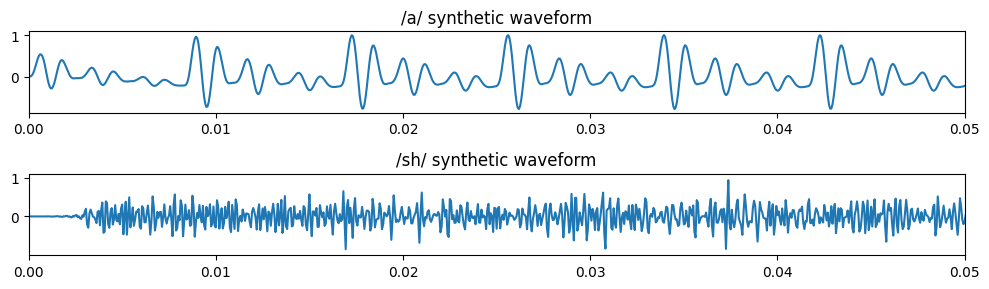

In [4]:
# ---------- /a/ synthetic ----------
f0 = 120.0               # pitch (Hz)
Nh = 30                  # number of harmonics
# harmonic amplitudes: decay ~ 1/k
harmonics = sum((1/k) * np.sin(2*np.pi*k*f0*t) for k in range(1, Nh+1))

# --- 3 formant resonances typical for /a/ ---
formants = [(730, 80), (1090, 90), (2440, 120)]  # (freq, bandwidth) in Hz

def formant_filter(formants, fs):
    b = [1.0]
    a = [1.0]
    for f, bw in formants:
        r = np.exp(-np.pi * bw / fs)
        theta = 2 * np.pi * f / fs
        # Each formant adds conjugate poles
        a_f = [1, -2*r*np.cos(theta), r**2]
        a = np.convolve(a, a_f)
    return b, a

b_a, a_a = formant_filter(formants, fs)
x_a = sig.lfilter(b_a, a_a, harmonics)
x_a /= np.max(np.abs(x_a))  # normalize

# ---------- /sh/ synthetic ----------
# white noise filtered by a highpass / spectral tilt
N = len(t)
noise = np.random.randn(N)
# simple 1st order high-pass + gentle emphasis of 2–6 kHz
b_sh = sig.firwin(101, [2000, 6000], pass_zero=False, fs=fs)
x_sh = sig.lfilter(b_sh, [1.0], noise)
x_sh /= np.max(np.abs(x_sh))

# ---------- visualize ----------
plt.figure(figsize=(10,3))
plt.subplot(2,1,1)
plt.plot(t, x_a)
plt.title("/a/ synthetic waveform"); plt.xlim(0, 0.05)
plt.subplot(2,1,2)
plt.plot(t, x_sh)
plt.title("/sh/ synthetic waveform"); plt.xlim(0, 0.05)
plt.tight_layout()
plt.show()

### Forward Prediction
2. Para las grabaciones del punto 1, realicen una predicción forward y representen el error MSE mínimo $J$ en función de $M$. Notarán dos codos para /a/ y un codo para /sh/. ¿A qué se deben estos codos? Justifiquen. Recomendación: investiguen la señal de error $e^f(n)$

1. for each M find the autocorrelation stuff to get forward error
2. find J from MSE as mean(forward error^2)
3. graph J vs M 

In [23]:
# forward preiction to find J(M) and graph it
# expanded equations: R [1 a_o] = [J_o 0]

def pred_forward(M, r_full, midpoint):
    r = r_full[midpoint:midpoint+M+1]  # getting only positive lags up to M r(0...M)
    R = r[:-1]  # R(n-1), the autocorrelation sequence for first M values r(0...M-1)
    r_f = r[1:]  # r^f(n), the autocorrelation sequence r(1...M) for currently sample x(n) with prev M samples
    a_o = la.solve_toeplitz((R, R), -r_f)  # solving R(n−1)ao​(n)=−rf​(n)
    sigma_x = r[0]
    J_o = sigma_x + r_f.T @ a_o
    return J_o, a_o

M_tab = [1, 2, 4, 6, 8, 10, 12, 16, 20, 24, 32]
J_a_tab = []
J_sh_tab = []
a_o_a_tab = []
a_o_sh_tab = []

for i, x in enumerate([x_a, x_sh]):
    x -= np.mean(x)  # making signal zero mean
    r_full = sig.correlate(x, x)  # full autocorrelation sequence
    midpoint = len(r_full)//2
    for M in M_tab:
        J_o, a_o = pred_forward(M, r_full, midpoint)

        if i == 0:  # first round
            J_a_tab.append(J_o)
            a_o_a_tab.append(a_o)
        else:  # second round
            J_sh_tab.append(J_o)
            a_o_sh_tab.append(a_o)

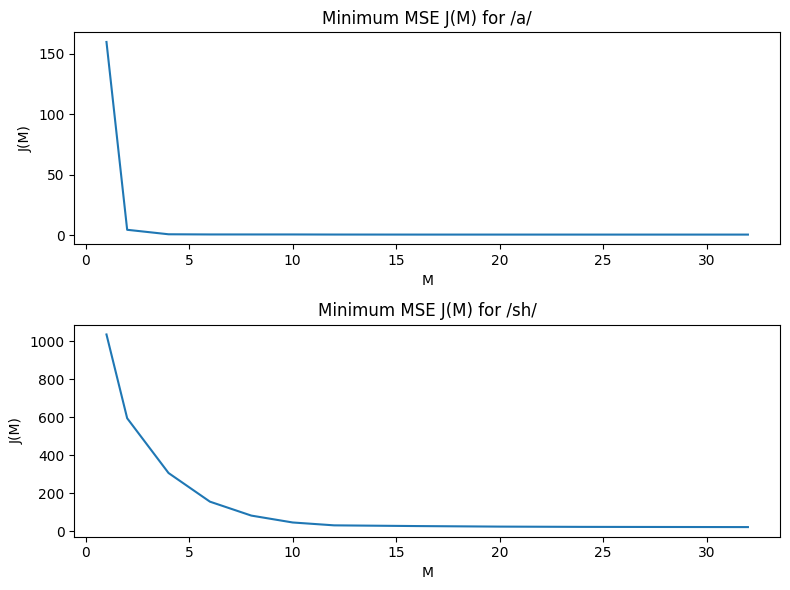

In [24]:
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(M_tab, J_a_tab)
plt.xlabel("M")
plt.ylabel("J(M)")
plt.title("Minimum MSE J(M) for /a/")
plt.subplot(2,1,2)
plt.plot(M_tab, J_sh_tab)
plt.title("Minimum MSE J(M) for /sh/")
plt.xlabel("M")
plt.ylabel("J(M)")
plt.tight_layout()
plt.show()

In [ ]:
# investigating the forward error

### Filtro del error de predicción
3. Para las grabaciones del punto 1, representen la respuesta en frecuencia $H(e^{j\omega})$ del filtro del error de predicción $\boldsymbol{\bar{a}}$ (no el filtro predictor $\boldsymbol{a}$) para $M = 1, 2, 4, 8, 16, 32, 64$. Expliquen y justifiquen los resultados obtenidos, teniendo en cuenta $J(M)$ y $e^f(n)$.

C:\Users\syane\AppData\Local\Temp\ipykernel_9676\2168928061.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


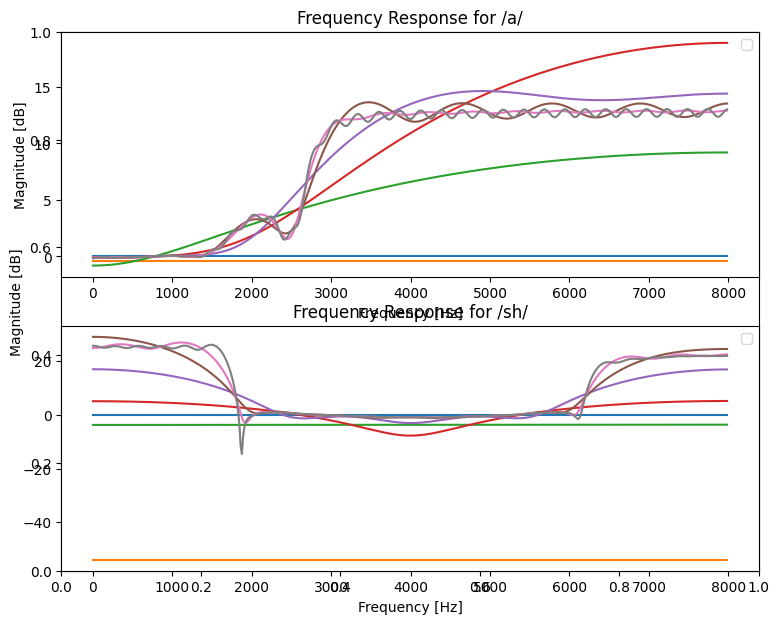

In [40]:
# H(e^jw) of filtro del error for M=1,2,4,...
M_tab = [1, 2, 4, 8, 16, 32, 64]
a_o_a_tab = [1]  # first coefficient is just 1
a_o_sh_tab = [1]

for i, x in enumerate([x_a, x_sh]):
    x -= np.mean(x)  # making signal zero mean
    r_full = sig.correlate(x, x)  # full autocorrelation sequence
    midpoint = len(r_full)//2
    for M in M_tab:
        _, a_o = pred_forward(M, r_full, midpoint)

        if i == 0:  # first round
            a_o_a_tab.append(-a_o)
        else:  # second round
            a_o_sh_tab.append(-a_o)

plt.figure(figsize=(9,7))
for i, a_o_list in enumerate([a_o_a_tab, a_o_sh_tab]):  # for both signals
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude [dB]")

    if i == 0:
        plt.subplot(2,1,1)
        plt.title("Frequency Response for /a/")
    else:
        plt.subplot(2,1,2)
        plt.title("Frequency Response for /sh/")

    for a_o in a_o_list:  # for each set of coeffs (from the M values)
        w, H = sig.freqz(a_o, fs=fs)  # magnitude and phase response 
        magnitude = 20 * np.log10(np.abs(H) + 10**(-12))

        plt.plot(w, magnitude)
        plt.legend()

### Applicando un filtro inverso
4. Para las grabaciones del punto 1, y con un valor apropiado de $M$ (donde termina el primer codo, no el segundo), resinteticen la señal de error con un modelo diseñado por ustedes (en base a lo observado en el punto 2) y fíltrenla con el filtro inverso del filtro del error de predicción $\boldsymbol{\bar{a}}$. Escuchen el resultado y compárenlo con la grabación original. Expliquen las diferencias. Justifiquen

In [ ]:
# take the M for the first elbow
# choose an appropriate model to resynthesise the error signal
# filter original signal with the inverse of the error filter

### Comparando una señal sumada
5. Realicen una grabación de voz a libre elección (larga) con $f_s = 16 kHz$. Utilizando ventanas de Hann de largo 50 ms con un overlap del 50%, realicen la predicción forward para cada bloque con $M = 12$, reemplacen las respectivas señales de error por un tren de impulsos (coherente entre bloques) de frecuencia $f_s = 160 Hz$, filtren las señales de error con el filtro inverso del filtro del error de predicción $\boldsymbol{\bar{a}}$, ventaneen cada resultado con una ventana de Hann, y sumen los resultados en su tiempo correspondiente. Escuchen la señal sumada y comparen con la grabación. ¿Qué ocurre? Justifiquen.

In [ ]:
# window the signal
# forward prediction of each block 
# replace the error signals with a train of impulses 
# fitler the error signals with the inverse filter of the error de prediccion
# window each result 
# sum the results in their respective time 